# **Import**

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import pickle
import json
import time
from os import listdir
from os.path import isfile, join
import os
import sys

from sklearn import metrics
from sklearn.metrics import classification_report

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Input,Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, BatchNormalization,LSTM,Bidirectional
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D,UpSampling1D, Conv1DTranspose,GaussianNoise 
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import Callback
from keras.regularizers import l2 , l1, l1_l2
import tensorflow.keras.backend as kb
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split

In [4]:
base_train = "./Datasets/training_data"
base_test = "./Datasets/independent_data"

In [5]:
def fasta_to_df(path):
    with open(path, 'r') as file:
        text = file.read()
    lines = [line for line in text.split('\n') if len(line) > 0]
    s = ''
    ids = []
    proteins = []
    for l in lines:
        if(l[0]=='>'):
            ids.append(l)        
            proteins.append(s)
            s = ''
        else:
            s += l    
    proteins.append(s)
    df = pd.DataFrame({'ids': ids,'protein': proteins[1:]})
    df['ids'] = df['ids'].apply(lambda x: x[-1])    
    return df

In [6]:
feature_base = './Feature_extraction/'

In [7]:
def get_feature(species = 'E',type='train'):
    BLOSUM = pd.read_csv(feature_base + f'BLOSUM62/BLOSUM62_{species}_{type}.csv')
    DDE = pd.read_csv(feature_base + f'DDE/DDE_{species}_{type}.csv')
    EAAC = pd.read_csv(feature_base + f'EAAC/EAAC_{species}_{type}.csv')
    EGAAC = pd.read_csv(feature_base + f'EGAAC/EGAAC_{species}_{type}.csv')
    KNN = pd.read_csv(feature_base + f'KNN/KNN_{species}_{type}.csv')
    return pd.concat([BLOSUM, DDE, EAAC, EGAAC, KNN],axis=1)

# Ecoli

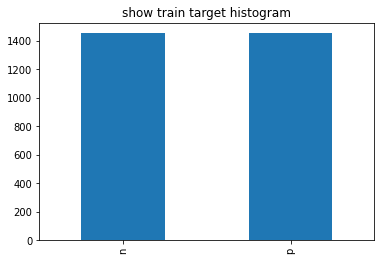

,ids,protein
0,p,YLVDVILDEAANKGTGKWTSQSALD
1,p,TESVFARYISSLKDQRVAASKVLSG


In [8]:
ecoli_train = fasta_to_df(base_train + "/ecoli_train.fasta")
ax = ecoli_train['ids'].value_counts(sort=False).plot(kind='bar',title='show train target histogram')
plt.show()
ecoli_train.head(2)

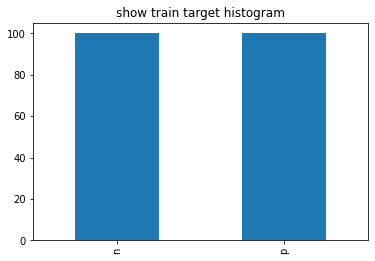

,ids,protein
0,p,LEMAQNAARLGWKAEKVDARLHHIM
1,p,IDLFRTLIQAVAKVTGATDLSNKSL


In [9]:
ecoli_test = fasta_to_df(base_test  + "/ecoli_test.fasta")
ax = ecoli_test['ids'].value_counts(sort=False).plot(kind='bar',title='show train target histogram')
plt.show()
ecoli_test.head(2)

# H

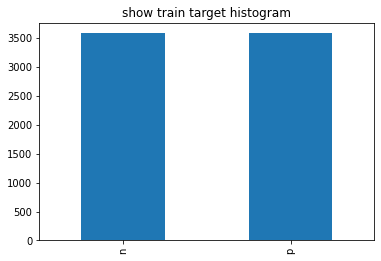

,ids,protein
0,p,KMLYVPVMPGHAKRLKLTMHKLVKP
1,p,INSQIKIDAHLNKVCPTTETIYNDE


In [10]:
H_train = fasta_to_df(base_train + "/H_train.fasta")
ax = H_train['ids'].value_counts(sort=False).plot(kind='bar',title='show train target histogram')
plt.show()
H_train.head(2)

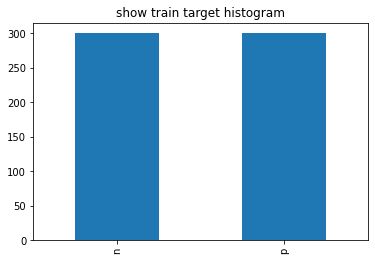

,ids,protein
0,p,KMLYVPVMPGHAKRLKLTMHKLVKP
1,p,INSQIKIDAHLNKVCPTTETIYNDE


In [11]:
H_test = fasta_to_df(base_test  + "/H_test.fasta")
ax = H_test['ids'].value_counts(sort=False).plot(kind='bar',title='show train target histogram')
plt.show()
H_train.head(2)

# mus

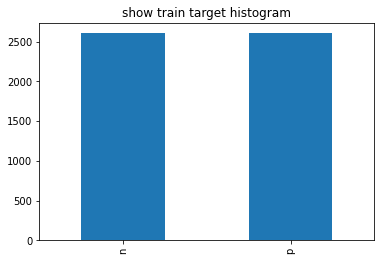

,ids,protein
0,p,GLSLNDRKKLLAKDLRGEMTLPATD
1,p,YKKDLAKRLLVGKSASVDAEKSMLS


In [12]:
mus_train = fasta_to_df(base_train + "/mus_train.fasta")
ax = mus_train['ids'].value_counts(sort=False).plot(kind='bar',title='show train target histogram')
plt.show()
mus_train.head(2)

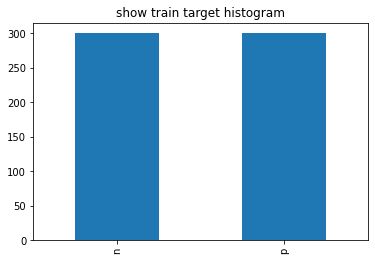

,ids,protein
0,p,ADSEAVTYQKLVKGHAYSVTGAEEV
1,p,DLHSEFDEQHGKKVPTVSRPYSFIE


In [13]:
mus_test = fasta_to_df(base_test  + "/mus_test.fasta")
ax = mus_test['ids'].value_counts(sort=False).plot(kind='bar',title='show train target histogram')
plt.show()
mus_test.head(2)

# Some info

In [14]:
print(f'ecoli_train shape: {ecoli_train.shape}')
print(f'ecoli_test shape: {ecoli_test.shape}')
print(f'H_train shape: {H_train.shape}')
print(f'H_test shape: {H_test.shape}')
print(f'mus_train shape: {mus_train.shape}')
print(f'mus_train shape: {mus_train.shape}')

ecoli_train shape: (2906, 2)
ecoli_test shape: (200, 2)
H_train shape: (7170, 2)
H_test shape: (600, 2)
mus_train shape: (5212, 2)
mus_train shape: (5212, 2)


# Encoding

In [15]:
Amino_acid = ['A','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','V','W','Y']
def encode(inp):
    out = np.zeros((inp.shape[0],21,1),dtype=float)
    for i in range(inp.shape[0]):        
        for p in inp[i]:
            out[i, Amino_acid.index(p)] += 1    
        out[i,:] = out[i,:] / out[i,:].sum()
    return  out.astype("float32")

def Normalize(df):
    return (df - df.min()) / (df.max()-df.min())    

ecoli_train_X = Normalize(encode(ecoli_train['protein']))
ecoli_test_X  = Normalize(encode(ecoli_test['protein']))
H_train_X     = Normalize(encode(H_train['protein']))
H_test_X      = Normalize(encode(H_test['protein']))
mus_train_X   = Normalize(encode(mus_train['protein']))
mus_test_X    = Normalize(encode(mus_test['protein']))

In [16]:
ecoli_train_X = get_feature(species='E',type='train')
ecoli_test_X  = get_feature(species='E',type='test')
H_train_X     = get_feature(species='H',type='train')
H_test_X      = get_feature(species='H',type='test')
mus_train_X   = get_feature(species='M',type='train')
mus_test_X    = get_feature(species='M',type='test')

# One-hot

In [17]:
def one_hot(inp):
    out = np.zeros((inp.shape[0],2),dtype=int)
    for i in range(inp.shape[0]):        
        for id in inp[i]:
            if(id == "p"):
                out[i,0] = 1
            else:
                out[i,1] = 1                
    return out.astype("float32")

In [18]:
ecoli_train_Y = one_hot(ecoli_train['ids'])
ecoli_test_Y  = one_hot(ecoli_test['ids'])
H_train_Y     = one_hot(H_train['ids'])
H_test_Y      = one_hot(H_test['ids'])
mus_train_Y   = one_hot(mus_train['ids'])
mus_test_Y    = one_hot(mus_test['ids'])

# Select a dataset

In [19]:
X = np.concatenate((ecoli_train_X, H_train_X,mus_train_X), axis=0)
Y = np.concatenate((ecoli_train_Y, H_train_Y,mus_train_Y), axis=0)
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_train = (X_train - X_train.mean()) / X_train.std()
X_val = X_val.reshape(( X_val.shape[0], X_val.shape[1],1))
X_val = (X_val - X_val.mean()) / X_val.std()

# Buil a classifier model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 1434, 256)         1024      
_________________________________________________________________
batch_normalization_3 (Batch (None, 1434, 256)         1024      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 478, 256)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 478, 256)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 476, 256)          196864    
_________________________________________________________________
batch_normalization_4 (Batch (None, 476, 256)          1024      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 158, 256)         

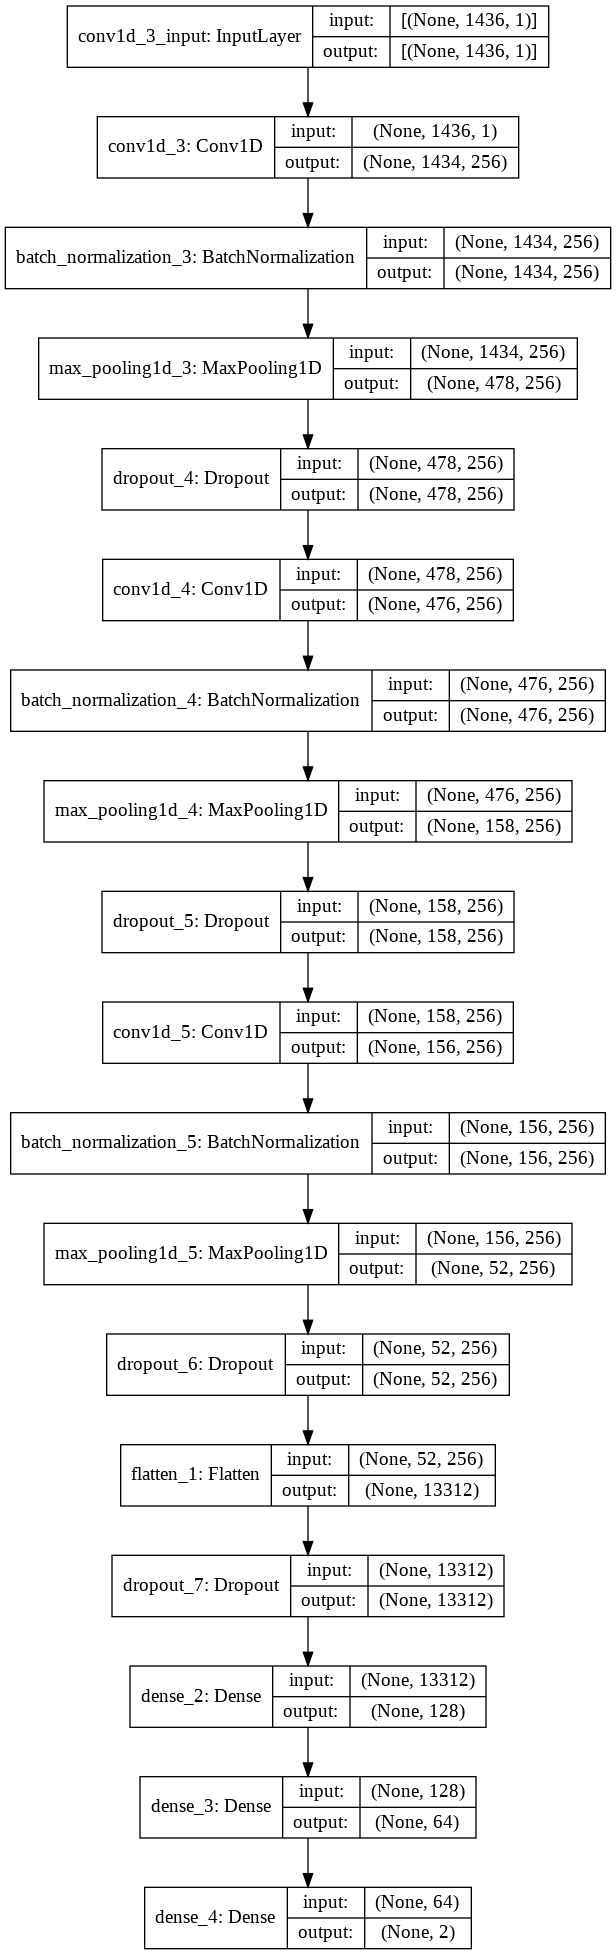

In [21]:
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=3, activation='relu',input_shape=(X.shape[1],1))) 
model.add(BatchNormalization())
model.add(MaxPooling1D(3))
model.add(Dropout(0.5))

model.add(Conv1D(filters=256, kernel_size=3, activation='relu')) 
model.add(BatchNormalization())
model.add(MaxPooling1D(3))
model.add(Dropout(0.5))

model.add(Conv1D(filters=256, kernel_size=3, activation='relu')) 
model.add(BatchNormalization())
model.add(MaxPooling1D(3))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

print(model.summary())
model.compile(loss='categorical_crossentropy',optimizer = tf.keras.optimizers.Adam(),metrics = "acc") 
plot_model(model, "CNN.png", show_shapes=True)

# Trianing phase 


In [22]:
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath='./Models/CNN_Model{epoch}.h5',
                                                  monitor='val_loss',save_best_only=True)                                                                                                  
                  ,keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]                                                               


history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list,
                    verbose=1)

json.dump(str(history.history), open(f'./CNN_History.pkl', "w"))
model.save(f'./CNN_Model.h5')

Epoch 1/100
192/192 [==============================] - 24s 109ms/step - loss: 0.3934 - acc: 0.8189 - val_loss: 3.0229 - val_acc: 0.4954
Epoch 2/100
192/192 [==============================] - 20s 106ms/step - loss: 0.3161 - acc: 0.8359 - val_loss: 1.3418 - val_acc: 0.5762
Epoch 3/100
192/192 [==============================] - 20s 107ms/step - loss: 0.3150 - acc: 0.8428 - val_loss: 0.4614 - val_acc: 0.7992
Epoch 4/100
192/192 [==============================] - 20s 106ms/step - loss: 0.3104 - acc: 0.8429 - val_loss: 0.2784 - val_acc: 0.8430
Epoch 5/100
192/192 [==============================] - 20s 106ms/step - loss: 0.2979 - acc: 0.8429 - val_loss: 0.3245 - val_acc: 0.8457
Epoch 6/100
192/192 [==============================] - 20s 106ms/step - loss: 0.2983 - acc: 0.8400 - val_loss: 0.2819 - val_acc: 0.8424
Epoch 7/100
192/192 [==============================] - 20s 106ms/step - loss: 0.2912 - acc: 0.8465 - val_loss: 0.3193 - val_acc: 0.8430
Epoch 8/100
192/192 [===========================

# Show result

In [23]:
plt.style.use('seaborn-whitegrid')  # 'Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10'

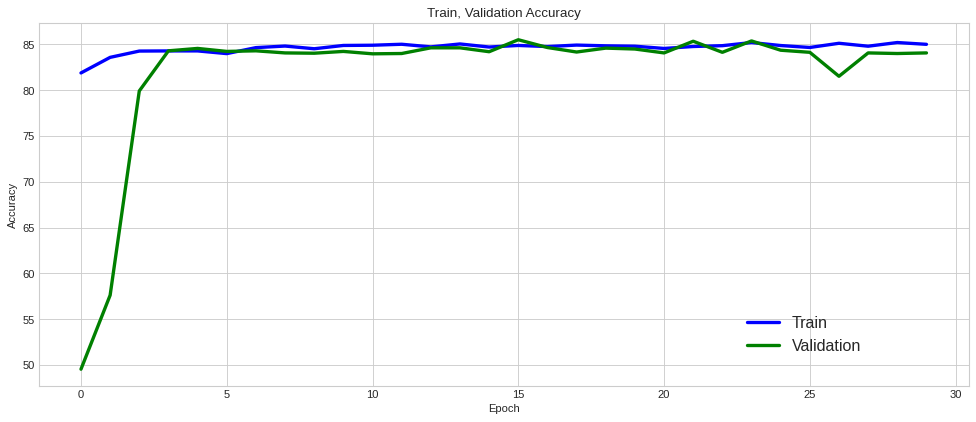

In [24]:
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.array(history.history['acc'])*100,'b',linewidth=3,markersize=7)
plt.plot(np.array(history.history['val_acc'])*100,'g',linewidth=3,markersize=7)
plt.title(f'Train, Validation Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right',bbox_to_anchor=(0.9, 0.05),fontsize='x-large',facecolor="white",markerscale=2,edgecolor='black')    
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

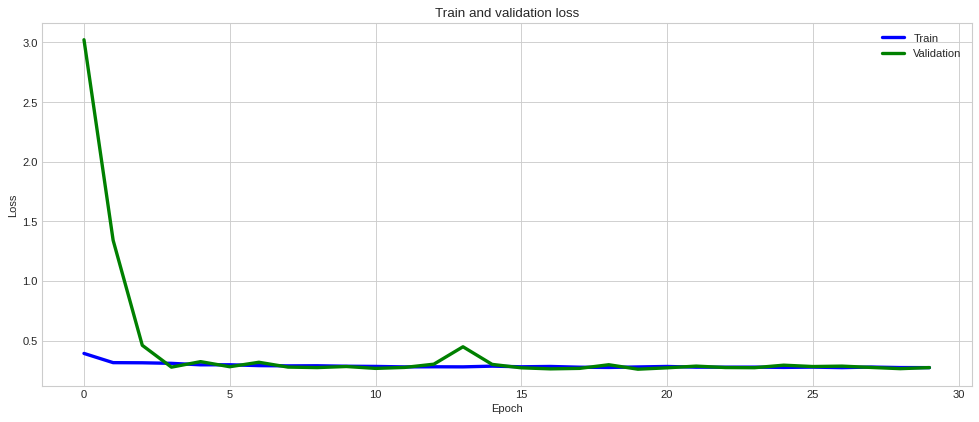

In [25]:
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(history.history['loss'],'b',linewidth=3)
plt.plot(history.history['val_loss'],'g',linewidth=3)
plt.title(f'Train and validation loss')
plt.legend(['Train', 'Validation'], loc='upper right')    
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Confusion metrix

In [26]:
LABELS = ['No Malonic', 'Malonic']
def confusion_matrix(validations, predictions):        
    matrix = metrics.confusion_matrix(validations, predictions)        
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,cmap="Blues",linecolor='white',linewidths=1,
                xticklabels=LABELS,yticklabels=LABELS,annot=True,fmt=".2f")    
    plt.title("Confusion Matrix")
    plt.ylabel("Actually Label")
    plt.xlabel("Predicted Label")
    plt.show()
    sensitivity =  np.divide(matrix.transpose(),np.sum(matrix, axis=1)).transpose() * 100
    plt.figure(figsize=(6, 4))
    sns.heatmap(sensitivity,cmap="Blues",linecolor='white',linewidths=1,
                xticklabels=LABELS,yticklabels=LABELS,annot=True,fmt=".2f")    
    plt.title("Confusion Matrix")
    plt.ylabel("Actually Label")
    plt.xlabel("Predicted Label")
    plt.show()

In [27]:
#model = keras.models.load_model('/content/drive/MyDrive/Malonic_Acid_Detection/CNN_Model.h5')


--- Confusion matrix for train data ---



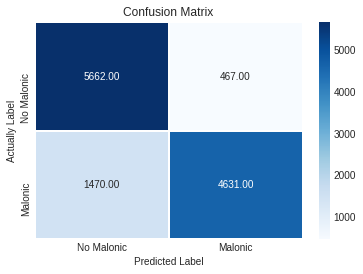

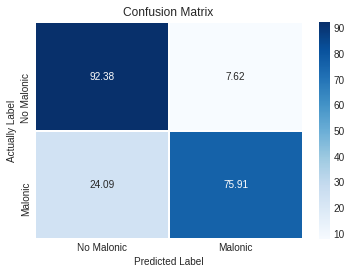

              precision    recall  f1-score   support

           0     0.7939    0.9238    0.8539      6129
           1     0.9084    0.7591    0.8270      6101

    accuracy                         0.8416     12230
   macro avg     0.8511    0.8414    0.8405     12230
weighted avg     0.8510    0.8416    0.8405     12230



In [28]:
print("\n--- Confusion matrix for train data ---\n")
y_true = np.argmax(y_train, axis=1)
y_pred =  np.argmax(model.predict(X_train), axis=1)
matrix = confusion_matrix(y_true,y_pred)
print(classification_report(y_true, y_pred,digits=4))

In [29]:
X = np.concatenate((ecoli_test_X, H_test_X,mus_test_X), axis=0)
Y = np.concatenate((ecoli_test_Y, H_test_Y,mus_test_Y), axis=0)
X = X.reshape((X.shape[0], X.shape[1],1))
X = (X-X.mean()) / X.std()


--- Confusion matrix for test data ---



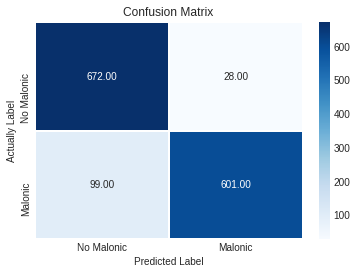

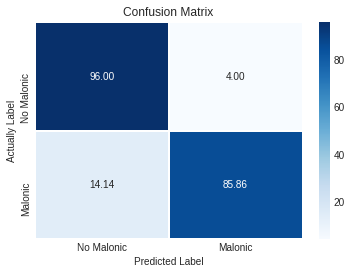

              precision    recall  f1-score   support

           0     0.8716    0.9600    0.9137       700
           1     0.9555    0.8586    0.9044       700

    accuracy                         0.9093      1400
   macro avg     0.9135    0.9093    0.9091      1400
weighted avg     0.9135    0.9093    0.9091      1400



In [30]:
print("\n--- Confusion matrix for test data ---\n")
y_true = np.argmax(Y, axis=1)
#x = ecoli_test_X.to_numpy()
#x = x.reshape((x.shape[0], x.shape[1],1))
y_pred =  np.argmax(model.predict(X), axis=1)
matrix = confusion_matrix(y_true,y_pred)
print(classification_report(y_true, y_pred,digits=4))

# Ecoli

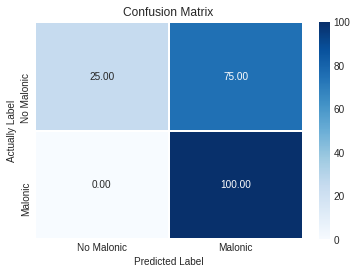

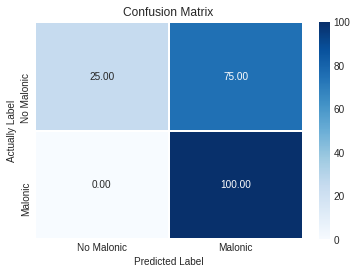

              precision    recall  f1-score   support

           0     1.0000    0.2500    0.4000       100
           1     0.5714    1.0000    0.7273       100

    accuracy                         0.6250       200
   macro avg     0.7857    0.6250    0.5636       200
weighted avg     0.7857    0.6250    0.5636       200



In [34]:
X = ecoli_test_X.to_numpy()
X = X.reshape((X.shape[0], X.shape[1],1))
Y = ecoli_test_Y
X = X.reshape((X.shape[0], X.shape[1],1))
X = (X-X.mean()) / X.std()
y_true = np.argmax(Y, axis=1)
y_pred =  np.argmax(model.predict(X), axis=1)
matrix = confusion_matrix(y_true,y_pred)
print(classification_report(y_true, y_pred,digits=4))

# H

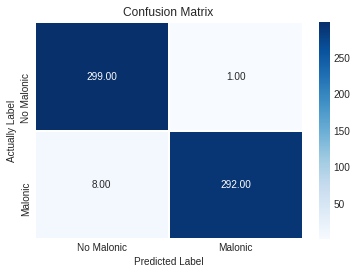

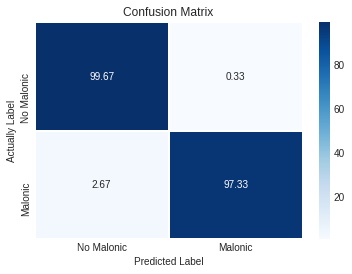

              precision    recall  f1-score   support

           0     0.9739    0.9967    0.9852       300
           1     0.9966    0.9733    0.9848       300

    accuracy                         0.9850       600
   macro avg     0.9853    0.9850    0.9850       600
weighted avg     0.9853    0.9850    0.9850       600



In [35]:
X = H_test_X.to_numpy()
X = X.reshape((X.shape[0], X.shape[1],1))
Y = H_test_Y
X = X.reshape((X.shape[0], X.shape[1],1))
X = (X-X.mean()) / X.std()
y_true = np.argmax(Y, axis=1)
y_pred =  np.argmax(model.predict(X), axis=1)
matrix = confusion_matrix(y_true,y_pred)
print(classification_report(y_true, y_pred,digits=4))

# M 

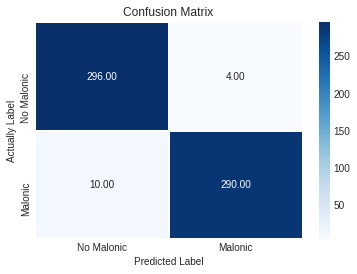

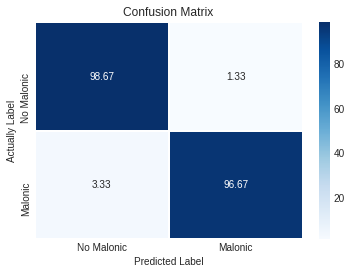

              precision    recall  f1-score   support

           0     0.9673    0.9867    0.9769       300
           1     0.9864    0.9667    0.9764       300

    accuracy                         0.9767       600
   macro avg     0.9769    0.9767    0.9767       600
weighted avg     0.9769    0.9767    0.9767       600



In [38]:
X = mus_test_X.to_numpy()
X = X.reshape((X.shape[0], X.shape[1],1))
Y = mus_test_Y
X = X.reshape((X.shape[0], X.shape[1],1))
X = (X-X.mean()) / X.std()
y_true = np.argmax(Y, axis=1)
y_pred =  np.argmax(model.predict(X), axis=1)
matrix = confusion_matrix(y_true,y_pred)
print(classification_report(y_true, y_pred,digits=4))